# Projet 7 : Proof Of Concept (POC)

L'objectif de ce projet est de faire une veille thématique. Dans le but de monter rapidement en compétences sur des nouveautés en machine learning. La thématique choisie est la super-résoltion. L'idée derrière cette thématique est de voir si l'on peut améliorer le projet sur la classification d'images de chien en augmentant la définition des images.

## Plan
* Explication de la super-résolution
* Augmentation de la définition des images

In [1]:
import os
import shutil
import PIL.Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


2021-08-23 08:02:13.844970: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Augmentation de la définition des images

Dans un premier temps on sélectionne 10 classes avec lesquels on va travailler :
* affenpinscher
* boxer
* German_shepherd
* Great_Pyrenees
* pug
* Australian_terrier
* dingo
* golden_retriever
* Irish_wolfhound
* Siberian_husky

On dépose ces images dans le dossier datasets/standard_resolution 
 
Dans un second temps on fait une copie de ce cette arborescence dans datasets/super_resolution

In [4]:
if not os.path.exists('./datasets/super_resolution'):
    shutil.copytree('./datasets/standard_resolution', './datasets/super_resolution')
    !./superes.sh

Ensuite on va appliquer la super-résolution a ces images grâce à l'application realesrgan-ncnn-vulkan téléchargé sur la page github : https://github.com/xinntao/Real-ESRGAN

Un petit script bash a été écrit pour parcourir les fichiers et lancer l'application sur chaque image

```bash
#!/bin/bash

cd datasets/super_resolution

# set -evx
for dir in */; do
    if [ -d "$dir" ]; then
        cd "$dir"
        echo $dir
        for f in *jpg; do
           echo ${f::-4}.png
           ../../../realesrgan-ncnn-vulkan -i $f -o ${f::-4}.png
           rm $f
        done
        cd ..
    fi
done

cd ../..
```



## Visualisation des images

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./datasets/standard_resolution',
    labels='inferred',
    seed=18)

Found 1778 files belonging to 10 classes.


In [6]:
num_classes = len(dataset.class_names)
print(f'Il y a {num_classes} classes de race de chien dans notre dataset')

Il y a 10 classes de race de chien dans notre dataset


On compte le nombre de fichier dans chaque dossier.

In [7]:
list_classes = []
list_size = []

basedir = os.path.abspath('./datasets/standard_resolution')
for name_class in os.listdir(basedir):
    class_path = os.path.join(basedir, name_class)
    list_classes.append(name_class)
    list_size.append(len(os.listdir(class_path)))

df = pd.DataFrame({'classes':list_classes, 'size':list_size})

On visualise le nombre d'images par races de chien.

<AxesSubplot:xlabel='size', ylabel='classes'>

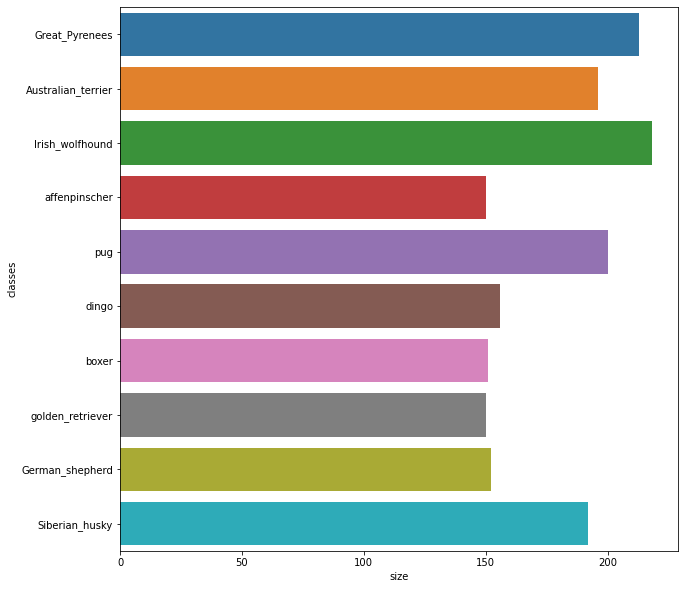

In [8]:
plt.figure(figsize=(10,10))
sns.barplot(x='size', y='classes', data=df)

Quelques images d'exemple du dataset. La méthode take d'un objet tf.data.Dataset permet d'extraire un objet tf.data.Dataset qui correspond à un batch d'images.

2021-08-23 08:02:14.089037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-23 08:02:14.108490: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4099895000 Hz


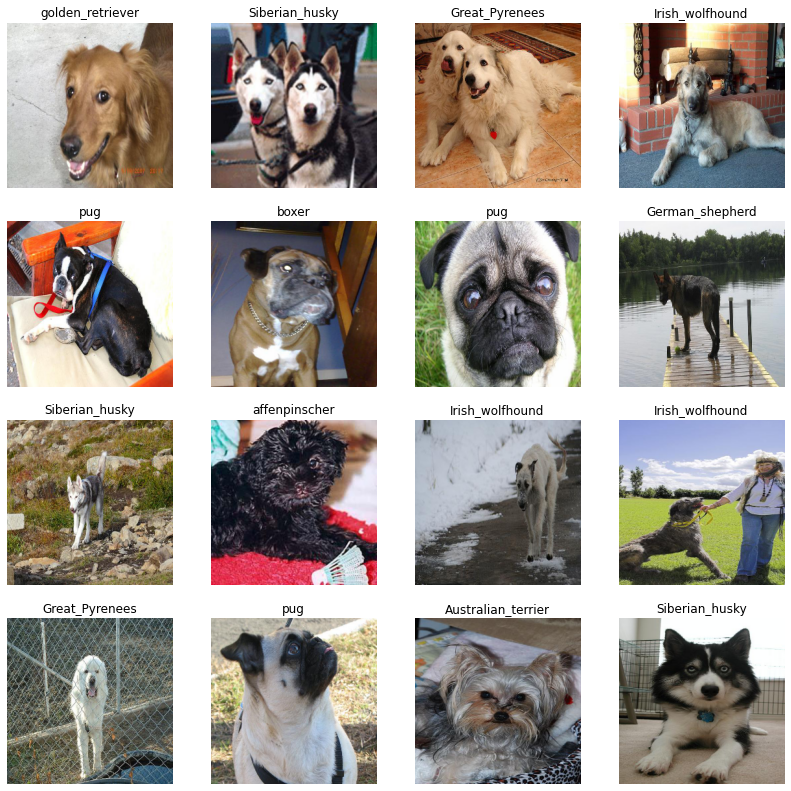

In [9]:
class_names = dataset.class_names

plt.figure(figsize=(14, 14))
for image_list, label_list in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_list[i].numpy().astype("uint8"))
    plt.title(class_names[label_list[i]])
    plt.axis("off")

### Sans super-résolution

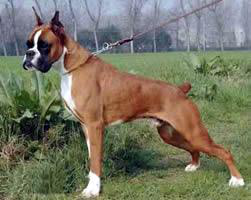

In [10]:
boxer_standard_img = 'datasets/standard_resolution/boxer/n02108089_14112.jpg'
PIL.Image.open(boxer_standard_img)

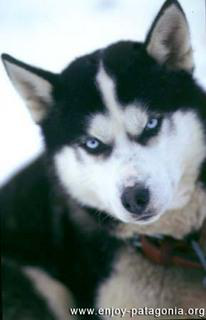

In [11]:
husky_standard_img = 'datasets/standard_resolution/Siberian_husky/n02110185_11626.jpg'
PIL.Image.open(husky_standard_img)

### Avec super-résolution

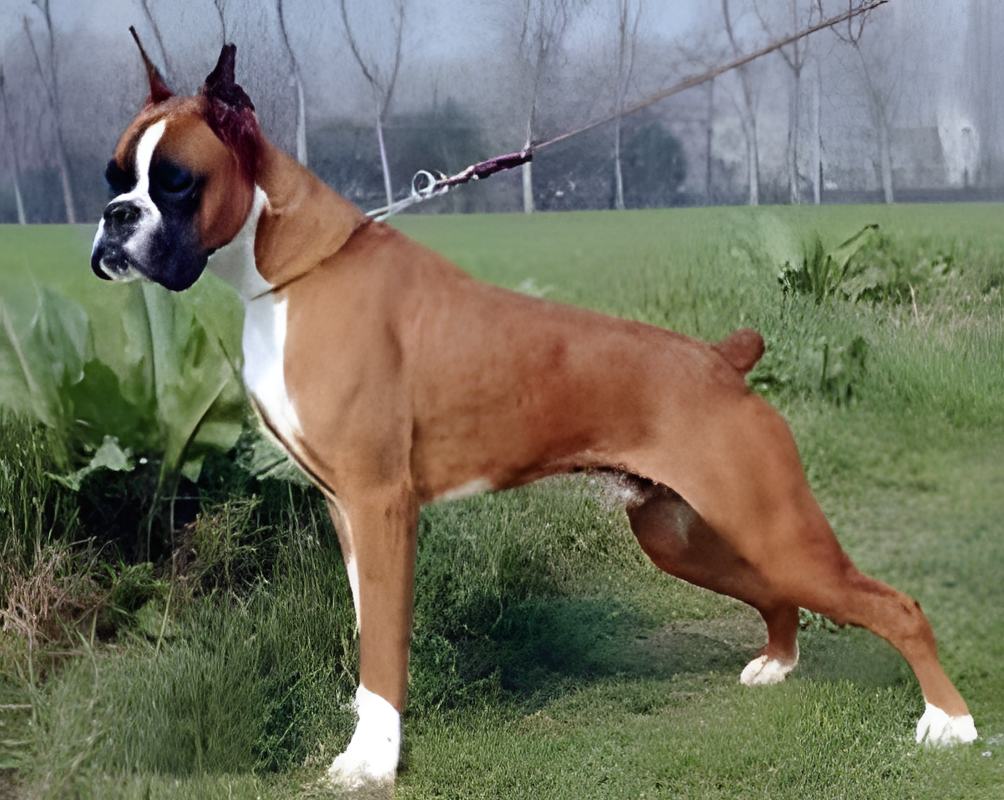

In [12]:
boxer_superes = 'datasets/super_resolution/boxer/n02108089_14112.png'
PIL.Image.open(boxer_superes)

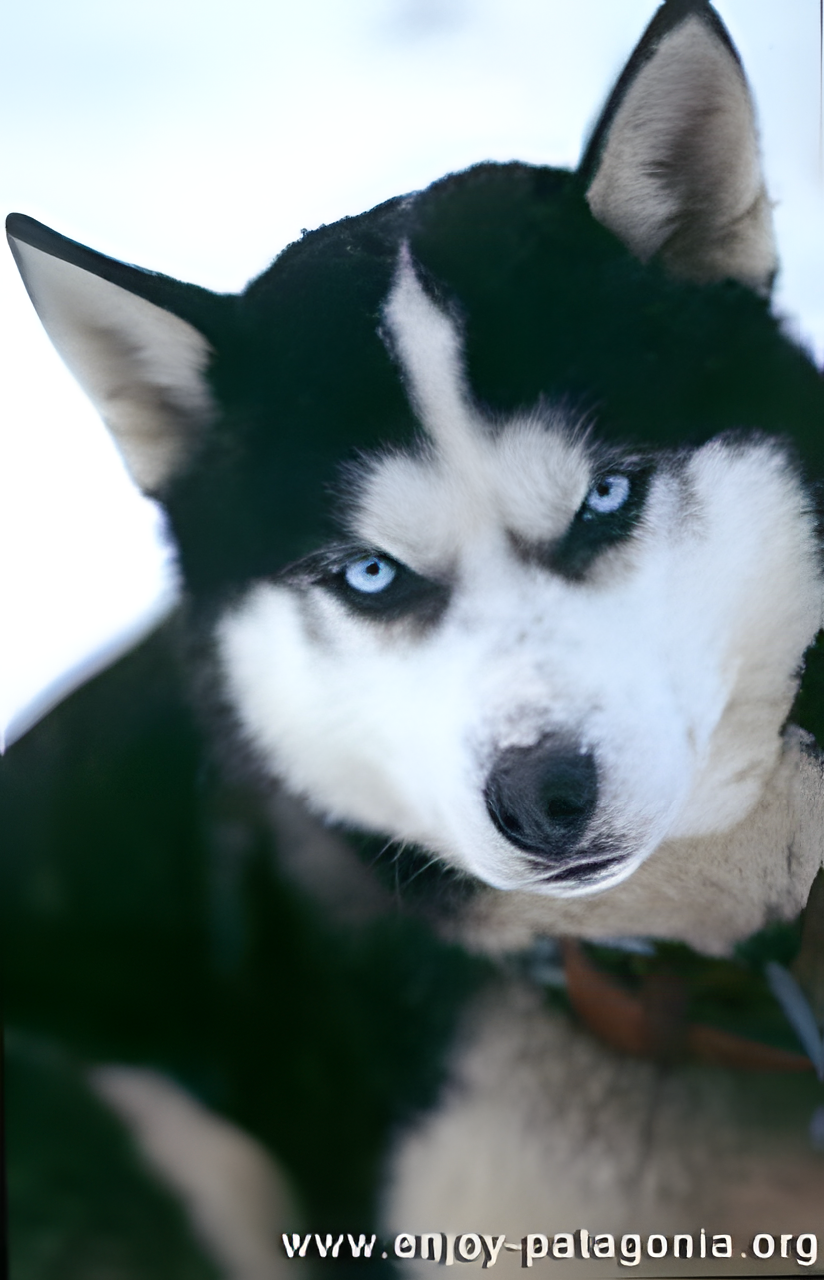

In [13]:
husky_superes = 'datasets/super_resolution/Siberian_husky/n02110185_11626.png'
PIL.Image.open(husky_superes)

## Approche CNN simple

On va définir un modèle CNN simple que l'on va évaluer sur :
* données standard et dimension image petite
* données super-résolution et dimension image petite
* données standard et dimension image grande
* données super-résolution et dimension image grande

In [14]:
os.makedirs('./results/CNN_simple/', exist_ok=True)

In [15]:
img_size_small = (160, 160)
img_shape_small = (160, 160, 3)
img_size_large = (640, 640)
img_shape_large = (640, 640, 3)

img_path_standard = './datasets/standard_resolution'
img_path_superes = './datasets/super_resolution'

### Définition du générateur d'images avec Data augmentation

In [16]:
def makeGenerator(img_path, img_size):
    
    no_augmentation_kwargs = dict(
        rescale=1./255,
        validation_split=0.2)
    
    augmentation_kwargs = dict(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        brightness_range=(0.1, 0.9),
        shear_range=45.0,
        zoom_range=[0.5, 1.5],
        channel_shift_range=150.0,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2)

    train_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**augmentation_kwargs)

    train_generator_augmentation = train_datagen_augmentation.flow_from_directory(
        directory=img_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=True)

    validation_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

    validation_generator_augmentation = validation_datagen_augmentation.flow_from_directory(
        directory=img_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False)
    
    return train_generator_augmentation, validation_generator_augmentation

### Définition du modèle

In [17]:
def makeModel(img_shape):
       
    model_base = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu')
    ])    
    
    prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
    
    inputs = tf.keras.Input(img_shape)
    x = model_base(inputs, training=True)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

### Evaluation du model

In [18]:
def evaluateModel(model, train_gen, validation_gen, results_path):
    
    os.makedirs(results_path, exist_ok=True)
   
    steps_per_epoch = train_gen.samples // train_gen.batch_size
    validation_steps = validation_gen.samples // validation_gen.batch_size

    if os.path.exists(results_path + 'history.npy'):
        history_dict = np.load(results_path + 'history.npy',allow_pickle='TRUE').item()
    else:
        history = model.fit(
        train_gen,
        epochs=30,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_gen,
        validation_steps=validation_steps)

        history_dict = history.history
        np.save(results_path + 'history.npy',history_dict)
        
    return history_dict

### Standard resolution small images

In [19]:
train_gen, validation_gen = makeGenerator(img_path_standard, img_size_small)

Found 1425 images belonging to 10 classes.
Found 353 images belonging to 10 classes.


In [20]:
model_StandardSmall = makeModel(img_shape_small)

In [21]:
history_StandardSmall = evaluateModel(model_StandardSmall, train_gen, validation_gen, './results/CNN_simple/StandardSmall/')

### Super resolution small images

In [22]:
train_gen, validation_gen = makeGenerator(img_path_superes, img_size_small)

Found 1425 images belonging to 10 classes.
Found 353 images belonging to 10 classes.


In [23]:
model_SuperesSmall = makeModel(img_shape_small)

In [24]:
history_SuperesSmall = evaluateModel(model_SuperesSmall, train_gen, validation_gen, './results/CNN_simple/SuperesSmall/')

### Standard resolution large images

In [25]:
train_gen, validation_gen = makeGenerator(img_path_standard, img_size_large)

Found 1425 images belonging to 10 classes.
Found 353 images belonging to 10 classes.


In [26]:
model_StandardLarge = makeModel(img_shape_large)

In [27]:
history_StandardLarge = evaluateModel(model_StandardLarge, train_gen, validation_gen, './results/CNN_simple/StandardLarge/')

### Super resolution large images

In [28]:
train_gen, validation_gen = makeGenerator(img_path_superes, img_size_large)

Found 1425 images belonging to 10 classes.
Found 353 images belonging to 10 classes.


In [29]:
model_SuperesLarge = makeModel(img_shape_large)

In [30]:
history_SuperesLarge = evaluateModel(model_SuperesLarge, train_gen, validation_gen, './results/CNN_simple/SuperesLarge/')

### Comparaison

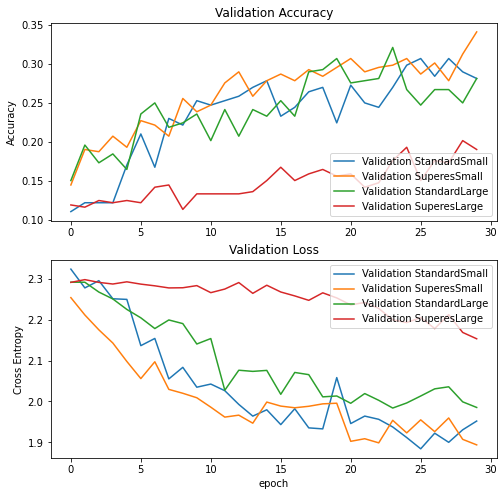

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_StandardSmall['val_accuracy'], label='Validation StandardSmall')
plt.plot(history_SuperesSmall['val_accuracy'], label='Validation SuperesSmall')
plt.plot(history_StandardLarge['val_accuracy'], label='Validation StandardLarge')
plt.plot(history_SuperesLarge['val_accuracy'], label='Validation SuperesLarge')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_StandardSmall['val_loss'], label='Validation StandardSmall')
plt.plot(history_SuperesSmall['val_loss'], label='Validation SuperesSmall')
plt.plot(history_StandardLarge['val_loss'], label='Validation StandardLarge')
plt.plot(history_SuperesLarge['val_loss'], label='Validation SuperesLarge')

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Validation Loss')
plt.xlabel('epoch')
plt.show()

## Approche Transfer Learning

On va définir un modèle utilisant le Transfer Learning que l'on va évaluer sur :
* données standard et dimension image petite
* données super-résolution et dimension image petite
* données standard et dimension image grande
* données super-résolution et dimension image grande

Dans le projet précedent on a montrer que le modèle DenseNet201 permettait d'avoir les meilleurs résultats en utilisant une taille d'image 160x160. Une optimisation a permis de déterminer la meilleure architecture à la suite de ce modèle.

La meilleur architecture obtenue a été :
* DenseNet201 sans la dernière couche
* couche de dropout de 0.4
* couche dense de 672 neurones
* couche de prédiction de 120 neurones (car 120 classes sur le projet précédent)

Avec learning rate de 1e-4

On va repartir de ce modèle pour faire notre comparaison. On va juste changer la couche de prédiction pour une couche dense de 10 neurones car 10 classes.

### Définition du générateur d'images avec Data augmentation

In [32]:
def makeTFGenerator(img_path, img_size):
    
    no_augmentation_kwargs = dict(
        validation_split=0.2)
    
    augmentation_kwargs = dict(
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        brightness_range=(0.1, 0.9),
        shear_range=45.0,
        zoom_range=[0.5, 1.5],
        channel_shift_range=150.0,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2)

    train_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
        **augmentation_kwargs,
        preprocessing_function=tf.keras.applications.densenet.preprocess_input)

    train_generator_augmentation = train_datagen_augmentation.flow_from_directory(
        directory=img_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=True)

    validation_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
        **no_augmentation_kwargs,
        preprocessing_function=tf.keras.applications.densenet.preprocess_input)

    validation_generator_augmentation = validation_datagen_augmentation.flow_from_directory(
        directory=img_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False)
    
    return train_generator_augmentation, validation_generator_augmentation

### Définition du modèle

In [33]:
def makeTFModel(img_shape):
       
    model_kwargs = dict(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=img_shape,
        pooling=None,
        classes=1000)
    
    base_model = tf.keras.applications.densenet.DenseNet201(**model_kwargs)
    base_model.trainable = False
    base_model.summary()
    
    global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
    
    inputs = tf.keras.Input(img_shape)
    x = base_model(inputs, training=False)
    x = global_avg_layer(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(672, activation='relu')(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

### Standard resolution small images

In [34]:
train_gen, validation_gen = makeTFGenerator(img_path_standard, img_size_small)

Found 1425 images belonging to 10 classes.
Found 353 images belonging to 10 classes.


In [35]:
model_TF_StandardSmall = makeTFModel(img_shape_small)

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [36]:
history_StandardSmall = evaluateModel(model_TF_StandardSmall, train_gen, validation_gen, './results/TF/StandardSmall/')

### Super resolution small images

In [37]:
train_gen, validation_gen = makeTFGenerator(img_path_superes, img_size_small)

Found 1425 images belonging to 10 classes.
Found 353 images belonging to 10 classes.


In [38]:
model_TF_SuperesSmall = makeTFModel(img_shape_small)

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 166, 166, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [39]:
history_SuperesSmall = evaluateModel(model_TF_SuperesSmall, train_gen, validation_gen, './results/TF/SuperesSmall/')

### Standard resolution large images

In [40]:
train_gen, validation_gen = makeTFGenerator(img_path_standard, img_size_large)

Found 1425 images belonging to 10 classes.
Found 353 images belonging to 10 classes.


In [41]:
model_TF_StandardLarge = makeTFModel(img_shape_large)

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 646, 646, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 320, 320, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 320, 320, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [42]:
history_StandardLarge = evaluateModel(model_TF_StandardLarge, train_gen, validation_gen, './results/TF/StandardLarge/')

### Super resolution large images

In [43]:
train_gen, validation_gen = makeTFGenerator(img_path_superes, img_size_large)

Found 1425 images belonging to 10 classes.
Found 353 images belonging to 10 classes.


In [44]:
model_TF_SuperesLarge = makeTFModel(img_shape_large)

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 646, 646, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 320, 320, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 320, 320, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [45]:
history_SuperesLarge = evaluateModel(model_TF_SuperesLarge, train_gen, validation_gen, './results/TF/SuperesLarge/')

Epoch 1/30
44/44 [==============================] - 581s 13s/step - loss: 2.3050 - accuracy: 0.1375 - val_loss: 2.0093 - val_accuracy: 0.3892
Epoch 2/30
44/44 [==============================] - 575s 13s/step - loss: 2.0845 - accuracy: 0.2693 - val_loss: 1.7603 - val_accuracy: 0.5256
Epoch 3/30
44/44 [==============================] - 575s 13s/step - loss: 1.9125 - accuracy: 0.3578 - val_loss: 1.5342 - val_accuracy: 0.6534
Epoch 4/30
44/44 [==============================] - 575s 13s/step - loss: 1.7415 - accuracy: 0.4431 - val_loss: 1.3128 - val_accuracy: 0.7670
Epoch 5/30
44/44 [==============================] - 577s 13s/step - loss: 1.5965 - accuracy: 0.5052 - val_loss: 1.1378 - val_accuracy: 0.7812
Epoch 6/30
44/44 [==============================] - 575s 13s/step - loss: 1.4406 - accuracy: 0.5663 - val_loss: 0.9927 - val_accuracy: 0.8466
Epoch 7/30
44/44 [==============================] - 575s 13s/step - loss: 1.3215 - accuracy: 0.6009 - val_loss: 0.8772 - val_accuracy: 0.8693
Epoch 

### Comparaison

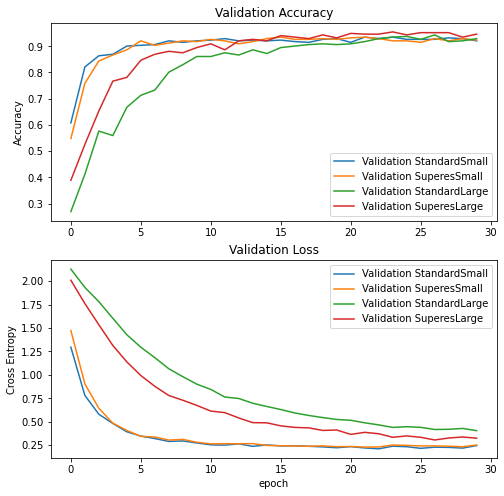

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_StandardSmall['val_accuracy'], label='Validation StandardSmall')
plt.plot(history_SuperesSmall['val_accuracy'], label='Validation SuperesSmall')
plt.plot(history_StandardLarge['val_accuracy'], label='Validation StandardLarge')
plt.plot(history_SuperesLarge['val_accuracy'], label='Validation SuperesLarge')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_StandardSmall['val_loss'], label='Validation StandardSmall')
plt.plot(history_SuperesSmall['val_loss'], label='Validation SuperesSmall')
plt.plot(history_StandardLarge['val_loss'], label='Validation StandardLarge')
plt.plot(history_SuperesLarge['val_loss'], label='Validation SuperesLarge')

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Validation Loss')
plt.xlabel('epoch')
plt.show()